In [1]:
import os
import numpy as np

from scipy import ndimage
from scipy.misc import imresize

from sklearn.utils import shuffle
from sklearn.cross_validation import StratifiedKFold
from keras.utils import np_utils

from sklearn.feature_extraction.image import extract_patches_2d

directory = './Images/'
# input image dimensions
# img_rows, img_cols = 1024, 1024
img_rows, img_cols = 128, 128

# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

patch_count = 10

def load(seed=123, set=0):
    X = []
    y = []
    
    X_test = []
    y_test = []
    
    for i in [2, 4]:
        cur_direct = directory + 'Cluster ' + str(i) + '/'
        j = 0
        label = i/2-1
        print(label)
        for jpg in os.listdir(cur_direct):
            j += 1
            
            x = ndimage.imread(cur_direct + jpg)
            patches = extract_patches_2d(x, (img_rows, img_cols), patch_count)
    
            if j >= (set*10) and j < (set*10+10):
                X_test.extend(patches)  
                y_test.extend([label] * patch_count)
            else:
                X.extend(patches)
                y.extend([label] * patch_count)

    
    X = np.asarray(X)
    X_test = np.asarray(X_test)
    y = np.asarray(y)
    y_test = np.asarray(y_test)
    
    print(X.shape)
    print(y.shape)
    X = X.reshape(X.shape[0], 3, img_rows, img_cols)
    X, y = shuffle(X, y, random_state=seed)  # shuffle train data
    
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    
    X = X.astype('float32')
    y = y.astype('float32')
    
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')
    return (X, y, X_test, y_test)

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

nb_classes = 2
accuracy = []
nb_epochs = 100
batch_size = 256

score_list = []
for i in range(10):
    X, y, X_test, y_test = load(set=i)
    print(X.shape)
    print(y.shape)

    X_train = X
    X_test = X_test
    y_train = y
    y_test = y_test

    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')
    print(y_train.shape, y_test.shape)

    print(np.unique(y_train))
    print(np.unique(y_test))
    # convert class vectors to binary class matrices
    # Y_train = np_utils.to_categorical(y_train, nb_classes)
    # Y_test = np_utils.to_categorical(y_test, nb_classes)
    Y_train = y_train
    Y_test = y_test

    model = Sequential()
    model.add(Convolution2D(32, 3, 3, border_mode='same',
                            input_shape=(3, img_rows, img_cols)))
    model.add(Activation('relu'))
    model.add(Convolution2D(32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    opt = Adam()
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255

    model.fit(X_train,Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),
              callbacks=[early_stop])

    score = model.evaluate(X_test, Y_test, verbose=0)
    score_list.append(score[1])
    print('Metrics', model.metrics_names)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    accuracy.append(score[1])
    print(accuracy)

0
1
(1980, 128, 128, 3)
(1980,)
(1980, 3, 128, 128)
(1980,)
('X_train shape:', (1980, 3, 128, 128))
(1980, 'train samples')
(180, 'test samples')
((1980,), (180,))
[ 0.  1.]
[ 0.  1.]
Train on 1980 samples, validate on 180 samples
Epoch 1/10
1980/1980 [==============================] - 24s - loss: 1.5077 - acc: 0.5040 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 2/10
1980/1980 [==============================] - 19s - loss: 0.6779 - acc: 0.6020 - val_loss: 0.6505 - val_acc: 0.8333
Epoch 3/10
1980/1980 [==============================] - 19s - loss: 0.4690 - acc: 0.8672 - val_loss: 0.4760 - val_acc: 0.8000
Epoch 4/10
1980/1980 [==============================] - 19s - loss: 0.3359 - acc: 0.8879 - val_loss: 0.6946 - val_acc: 0.6833
Epoch 5/10
1980/1980 [==============================] - 19s - loss: 0.2881 - acc: 0.8904 - val_loss: 0.5174 - val_acc: 0.7444
Epoch 6/10
1980/1980 [==============================] - 19s - loss: 0.1681 - acc: 0.9419 - val_loss: 0.4429 - val_acc: 0.7667
Epoch 7/10
19

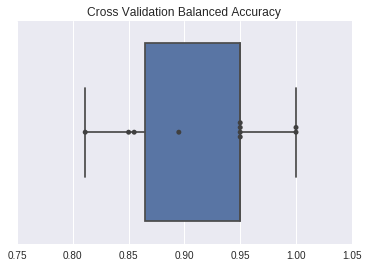

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
ax = sns.boxplot(score_list)
ax = sns.swarmplot(score_list, color=".25")
sns.plt.title('Cross Validation Balanced Accuracy')
#plt.boxplot(score_list, 1, 'gD', ylim)